In [67]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import warnings

In [2]:
warnings.filterwarnings('ignore')


##### Importo dati delle azioni dell'indice e facciola log dei return

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/Stoxx 600 Originale.xlsm'

In [5]:
stocks =df = pd.read_excel('/content/drive/MyDrive/Stoxx 600 Originale.xlsm',sheet_name = "Price daily", skiprows = [0],
                      parse_dates = [1]) 

In [6]:
stocks.shape

(4414, 1256)

In [7]:
stocks = stocks.iloc[2870:]

In [8]:
stocks.set_index(stocks["Dates"], inplace = True)
stocks.drop("Dates", axis = 1, inplace = True)

## Log returns stocks dataset

In [9]:
log_returns_stocks = pd.DataFrame()
for firm in stocks.columns:      
    log_returns_stocks[firm] = np.log(stocks[firm]) - np.log(stocks[firm].shift(1))
log_returns_stocks = log_returns_stocks[1:]  #remove first row, is all NaN 

In [10]:
log_returns_stocks.head()

,BP_PLC,Vodafone_Group_PLC,GlaxoSmithKline_PLC,HSBC_Holdings_PLC,TOTAL_SA,Novartis_AG,Royal_Dutch_Petroleum_Co,Nestle_SA,Nokia_OYJ,Shell_Transport_&_Trading_Co_Ltd/The,...,LPP_SA,AAK_AB,Valmet_OYJ,Nemetschek_SE,Galenica_AG,Tritax_Big_Box_REIT_PLC,Bechtle_AG,DiaSorin_SpA,Evotec_AG,Linde_PLC
Dates,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.016632,0.020686,0.018897,0.030094,0.024436,0.000000,0.0,0.000000,0.065478,0.0,...,-0.030639,0.006337,NaN,0.000000,NaN,NaN,0.009094,0.005927,0.024079,NaN
2013-01-03,0.023610,-0.000534,0.003456,-0.005037,-0.003006,0.020038,0.0,0.015977,0.024037,0.0,...,0.017432,0.004183,NaN,0.029091,NaN,NaN,0.003872,0.003932,0.017687,NaN
2013-01-04,0.024210,0.014539,0.010961,0.005514,-0.000879,0.012050,0.0,0.005950,0.007472,0.0,...,0.019130,0.004024,NaN,-0.007872,NaN,NaN,0.003857,-0.000327,0.001095,NaN
2013-01-07,-0.012179,-0.004148,-0.008549,-0.003747,-0.016841,-0.003448,0.0,-0.004182,0.017221,0.0,...,0.024209,0.007699,NaN,-0.000236,NaN,NaN,0.003715,-0.008541,0.010885,NaN
2013-01-08,0.000363,0.016994,0.001009,-0.010647,0.005857,0.005766,0.0,-0.005906,-0.064213,0.0,...,0.013536,-0.016575,NaN,-0.001889,NaN,NaN,-0.023806,-0.004298,-0.003615,NaN


##### Importo dati del return del nostro indice e facciola log dei return

In [11]:
index_return = pd.read_excel(path , sheet_name = "AC", parse_dates = [1], index_col = "Dates")

In [12]:
index_return.iloc[2870:].drop(columns = ['Dates.1','SXXP Index'])

,Sxxp index
Dates,
2013-01-01,279.68
2013-01-02,285.33
2013-01-03,286.83
2013-01-04,287.83
2013-01-07,286.63
...,...
2018-11-26,358.33
2018-11-27,357.40
2018-11-28,357.39


In [13]:
log_returns_index = pd.DataFrame()
log_returns_index["STOXXP"] = np.log(index_return["Sxxp index"]) - np.log(index_return["Sxxp index"].shift(1))
log_returns_index = log_returns_index[1:] 

In [14]:
log_returns_index = log_returns_index.iloc[2869:]
log_returns_index

,STOXXP
Dates,
2013-01-01,0.000000
2013-01-02,0.020000
2013-01-03,0.005243
2013-01-04,0.003480
2013-01-07,-0.004178
...,...
2018-11-26,0.012214
2018-11-27,-0.002599
2018-11-28,-0.000028


In [15]:
log_returns_stocks.isna().sum().sum()

52284

#### Parameters

In [16]:
rolling_window = 180

## Create DF of given 180 days

In [17]:
def df_window(window):
     
    global log_returns_stocks 
    global log_returns_index
    
    df_stocks = log_returns_stocks.iloc[window: rolling_window + window]
    # df = df.reset_index()
    df_stocks.dropna(axis = 1, how='any', inplace=True)

    df_index = log_returns_index.iloc[window: rolling_window + window]
    
    return df_stocks, df_index

### Rolling regression

In [18]:
columns = ['Title', 'alpha','alpha_significance', 'beta', 'absolute_returns', 
           'specific_risk', 'systematic_risk','r2']

In [19]:
stock, index = df_window(0)

In [20]:
index

,STOXXP
Dates,
2013-01-01,0.000000
2013-01-02,0.020000
2013-01-03,0.005243
2013-01-04,0.003480
2013-01-07,-0.004178
...,...
2013-09-03,-0.003836
2013-09-04,0.001854
2013-09-05,0.007316


In [31]:
def parameters_df_window(days): # aggiungere df_stocks, df_index in caso
    global columns
    
    df_stocks, df_index = df_window(days)
    df_results = pd.DataFrame(columns = columns)
    df_index = sm.add_constant(df_index.values)
    
    for title in df_stocks.columns:
        regression = sm.OLS(df_stocks[title], df_index)
        result = regression.fit()
        values = {'Title': title, 'alpha': result.params[0], 'beta': result.params[1],'alpha_significance': result.pvalues[0],
                  'absolute_returns': sum(df_stocks[title]), 'specific_risk': result.resid.std(), 
                  'systematic_risk': result.params[1] ** 2 * df_index.std() ** 2, 'r2': result.rsquared }
        df_results = df_results.append(values, ignore_index=True)
    
    return df_results

# Select top n titles given a parameter

In [32]:
def top_titles(df_results, parameter):
    if parameter == 'high_r2':
        df_top_titles = df_results.sort_values(by='r2', ascending=False).head(60)
        
    elif parameter == 'high_specific_risk':
        df_top_titles = df_results.sort_values(by='specific_risk', ascending=False).head(60)
        
    elif parameter == 'absolute_returns':
        df_top_titles = df_results.sort_values(by='absolute_returns', ascending=False).head(60)
        
    elif parameter == 'high_beta' or parameter == 'low_beta':
        if parameter == 'high_beta':
            ascending = False
        else:
            ascending = True
            df_results = df_results[df_results["beta"] != 0]
        df_top_titles = df_results.sort_values(by='beta', ascending = ascending).head(60)
        
    elif parameter == 'high_alpha':
        df_top_titles = df_results.sort_values(by = 'aplha', ascending = False).head(60)

    elif parameter == 'significant_alpha':
        df_results = df_results[df_results['alpha_significance']<0.05]
        df_results = df_results[df_results['alpha']>0]
        if(df.results.shape[1] < 60):
            raise Exception("Not enought titles")
        df_top_titles = df_results.sort_values(by='alpha', ascending=False).head(60)
    
    elif parameter == 'high_systematic_risk' or parameter == 'low_systematic_risk':
        if parameter == 'low_systematic_risk':
            ascending = True
        else:
            ascending = False
        df_top_titles = df_results.sort_values(by='systematic_risk', ascending=ascending).head(60)
        
    elif parameter == 'high_alpha_high_beta':
        df_results = df_results[df_results['alpha'] > 0]
        df_top_titles = df_results.sort_values(by='beta', ascending=False).head(60)
        
    elif parameter == 'low_r2_high_specific_risk':
        df_results = df_results.sort_values(by=['r2'], ascending=True).head(60)
        df_results = df_results.head(int(len(titles) * 1/3))
        df_top_titles = df_results.sort_values(by='specific_risk', ascending=False).head(60)
        
    return df_top_titles 

In [33]:
def returns(df):
    returns = list()
    titles = list(df.columns)
    for title in titles:
        title_return = df[title].sum()
        returns.append(title_return)
        #if title_return == 0:
            #print(f"{title} has all nan values")
    
    n_titles = len(titles)
    zeri = returns.count(0)      #n.titoli completamente costituiti da nan
    returns = sum(returns)/(n_titles - zeri)
    
    return returns

### From a dataframe that has for each title (columns) all the returns for a given n. of days, find total return of portfolio

In [75]:
def portfolio_costr(parameter):
    
    global columns
    
    portfolio_returns = list()
    portfolio = pd.DataFrame(columns=['Date']+ [f'Stock{i}' for i in range(1,61)] +['Returns'])
    portfolio_history = pd.DataFrame(columns = columns)

    #df_stocks, df_index = df_window(0)
    df_results = parameters_df_window(0)
    
    values = top_titles(df_results,parameter)
    titles = values.iloc[:,0].to_list()
    
    portfolio_history = portfolio_history.append(values, ignore_index=True)
       
    days_range = log_returns_stocks.shape[0] - rolling_window
    end = 140
  
    for days in range(7, end, 7):

        stocks_window_returns = log_returns_stocks[titles][rolling_window + days - 7 : rolling_window + days]

        tmp_returns = returns(stocks_window_returns)
        portfolio_returns.append(tmp_returns)

        portfolio_row = {'Dates': log_returns_stocks.iloc[rolling_window + days].name}
        portfolio_row.update({f'Stock{i}': titles[i - 1] for i in range(1,61)})
        portfolio_row.update({"Returns" : tmp_returns})
        portfolio = portfolio.append(portfolio_row, ignore_index=True)
        
        df_results = parameters_df_window(days)
        values = top_titles(df_results,parameter)
        titles = values.iloc[:,0].to_list()
        portfolio_history = portfolio_history.append(values, ignore_index=True)
        
        print(f"{parameter}: Siamo al day {days} su {end}", end = "\r")

    portfolio_history = portfolio_history[:-60]
    dates = np.array(portfolio['Dates'])
    dates = np.repeat(dates, 60)
    portfolio_history['Dates'] = dates
    
    portfolio_history.set_index(["Dates"], inplace = True)
    portfolio.set_index(["Dates"], inplace = True)
    portfolio_returns = np.array(portfolio_returns)
    
    return portfolio, portfolio_returns, portfolio_history

#### Questa funzione va finita aggiungendo metriche etc. Prima di far runnare il codice controllare per sicurezza che salva bene le cose

#### Nella funzione sopra, quando si cicla col for, sostituire "end" con "days range"

In [39]:
parameters = ['high_r2', 'high_specific_risk', 'absolute_returns', 'high_alpha'
              'high_beta', 'low_beta', 'significant_alpha',
              'high_systematic_risk', 'low_systematic_risk']

Definzione funzioni per metriche

In [58]:
def annualized_returns(returns):
    return returns.mean() * 36

def annualized_returns_percentage(returns):
    return f'{np.round(annualized_returns(returns)*100, 2)}%'

#VOLATILITY 

def annualized_volatility(returns):
    return returns.std() * np.sqrt(36)
    
def annualized_volatility_percentage(returns):
    return f'{np.round(annualized_volatility(returns)*100, 2)}%'

In [76]:
#for parameter in parameters:
   
portfolio, portfolio_returns, portfolio_history = portfolio_costr('high_specific_risk')
     
  #metriche["Total returns"] = portfolio_returns       metriche è il dizionario delle metriche
metriche = {}
metriche = {'Total returns': annualized_returns_percentage(portfolio_returns), ' Volatility': annualized_volatility_percentage(portfolio_returns)} 
df_metriche = pd.DataFrame.from_dict(metriche, orient = "index")      # qui dentro va inserito il dizionario che hai creato delle metriche
    
portfolio.to_csv(f"{parameter}_portfolio.csv", index = True)
portfolio_history.to_csv(f"{parameter}_history.csv", index = True)
df_metriche.to_csv(f"{parameter}_metrics.csv")

In [81]:
portfolio

,Dates,Date,Stock1,Stock2,Stock3,Stock4,Stock5,Stock6,Stock7,Stock8,...,Stock53,Stock54,Stock55,Stock56,Stock57,Stock58,Stock59,Stock60,Returns,Investment
0,2013-09-20,NaN,Dexia_SA,Banco_de_Valencia_SA,Bankia_SA,Eurobank_Ergasias_SA,IVG_Immobilien_GmbH,National_Bank_of_Greece_SA,Seat_Pagine_Gialle_SpA,Piraeus_Bank_SA,...,Johnston_Press_PLC,Eurasian_Natural_Resources_Corp_Ltd,Evraz_PLC,ams_AG,Hellenic_Telecommunications_Organization,Alcatel_Lucent_SA,Mediaset_SpA,Siemens_Gamesa_Renewable_Energy_SA,0.017130,100.00
1,2013-10-01,NaN,Dexia_SA,Banco_de_Valencia_SA,Bankia_SA,Eurobank_Ergasias_SA,IVG_Immobilien_GmbH,National_Bank_of_Greece_SA,Seat_Pagine_Gialle_SpA,Piraeus_Bank_SA,...,Banca_Monte_dei_Paschi_di_Siena_SpA,Paysafe_Group_Ltd,Eurasian_Natural_Resources_Corp_Ltd,Kenmare_Resources_PLC,Hellenic_Telecommunications_Organization,ams_AG,Evraz_PLC,Mediaset_SpA,-0.016300,98.37
2,2013-10-10,NaN,Dexia_SA,Banco_de_Valencia_SA,Bankia_SA,Eurobank_Ergasias_SA,IVG_Immobilien_GmbH,National_Bank_of_Greece_SA,Seat_Pagine_Gialle_SpA,Piraeus_Bank_SA,...,Eurasian_Natural_Resources_Corp_Ltd,Heidelberger_Druckmaschinen_AG,Kenmare_Resources_PLC,ams_AG,Evraz_PLC,Eniro_AB,Alcatel_Lucent_SA,Banca_Popolare_di_Milano_Scarl,0.041842,102.49
3,2013-10-21,NaN,Dexia_SA,Banco_de_Valencia_SA,Bankia_SA,Eurobank_Ergasias_SA,IVG_Immobilien_GmbH,National_Bank_of_Greece_SA,Piraeus_Bank_SA,Seat_Pagine_Gialle_SpA,...,Nokia_OYJ,ams_AG,Evraz_PLC,Telecom_Italia_Media_SpA,Banca_Popolare_dell'Emilia_Romagna_Scrl,Heidelberger_Druckmaschinen_AG,Alcatel_Lucent_SA,Banca_Popolare_di_Milano_Scarl,0.044143,107.01
4,2013-10-30,NaN,Dexia_SA,Banco_de_Valencia_SA,Bankia_SA,Eurobank_Ergasias_SA,IVG_Immobilien_GmbH,National_Bank_of_Greece_SA,Piraeus_Bank_SA,Solarworld_AG,...,Evraz_PLC,Banco_Comercial_Portugues_SA,Alcatel_Lucent_SA,Banca_Popolare_dell'Emilia_Romagna_Scrl,Eurasian_Natural_Resources_Corp_Ltd,Heidelberger_Druckmaschinen_AG,Commerzbank_AG,Man_Group_PLC,-0.010595,105.88
5,2013-11-08,NaN,Dexia_SA,Banco_de_Valencia_SA,Bankia_SA,Eurobank_Ergasias_SA,IVG_Immobilien_GmbH,National_Bank_of_Greece_SA,Piraeus_Bank_SA,Solarworld_AG,...,Alcatel_Lucent_SA,Banca_Popolare_dell'Emilia_Romagna_Scrl,Banco_Comercial_Portugues_SA,Commerzbank_AG,Mediaset_SpA,Eurasian_Natural_Resources_Corp_Ltd,Ubisoft_Entertainment_SA,Man_Group_PLC,0.017087,107.69
6,2013-11-19,NaN,Dexia_SA,Banco_de_Valencia_SA,Bankia_SA,Eurobank_Ergasias_SA,IVG_Immobilien_GmbH,National_Bank_of_Greece_SA,Piraeus_Bank_SA,Solarworld_AG,...,Nokia_OYJ,Commerzbank_AG,Eurasian_Natural_Resources_Corp_Ltd,Heidelberger_Druckmaschinen_AG,Banco_Comercial_Portugues_SA,K+S_AG,Banca_Popolare_dell'Emilia_Romagna_Scrl,Singulus_Technologies_AG,-0.026423,104.84
7,2013-11-28,NaN,Dexia_SA,Bankia_SA,Eurobank_Ergasias_SA,IVG_Immobilien_GmbH,National_Bank_of_Greece_SA,Piraeus_Bank_SA,Solarworld_AG,Arcandor_AG,...,Commerzbank_AG,K+S_AG,Nokia_OYJ,Evraz_PLC,Eurasian_Natural_Resources_Corp_Ltd,Evotec_AG,Banco_Comercial_Portugues_SA,Banca_Popolare_dell'Emilia_Romagna_Scrl,0.003292,105.19
8,2013-12-09,NaN,Dexia_SA,Bankia_SA,Eurobank_Ergasias_SA,IVG_Immobilien_GmbH,National_Bank_of_Greece_SA,Piraeus_Bank_SA,Independent_News_&_Media_PLC,Arcandor_AG,...,Johnston_Press_PLC,Eurasian_Natural_Resources_Corp_Ltd,Banco_Comercial_Portugues_SA,Solocal_Group,Peugeot_SA,Commerzbank_AG,Ubisoft_Entertainment_SA,Evotec_AG,-0.019416,103.15
9,2013-12-18,NaN,Dexia_SA,Bankia_SA,Eurobank_Ergasias_SA,IVG_Immobilien_GmbH,National_Bank_of_Greece_SA,Independent_News_&_Media_PLC,Piraeus_Bank_SA,Solarworld_AG,...,Commerzbank_AG,Abengoa_SA,Peugeot_SA,Johnston_Press_PLC,Ubisoft_Entertainment_SA,Thomas_Cook_Group_PLC,Oxurion_NV,Hellenic_Telecommunications_Organization,-0.028185,100.24


In [61]:
metriche

{'Total returns': '17.7%', ' Volatility': '22.91%'}

In [77]:
portfolio = portfolio.reset_index()

In [79]:
Investment = 100
prima = True
#portfolio.reset_index(inplace = True)
for index in portfolio.index:
    if prima:
        #cash = round(100 + 100 * (portfolio.loc[index]["Returns"]), 2)
        portfolio.at[index, "Investment"] = Investment
        prima = False
        # print(type(cash))
    else:
        Investment = round(Investment + Investment * (portfolio.loc[index]["Returns"]),2)
        portfolio.at[index, "Investment"] = Investment

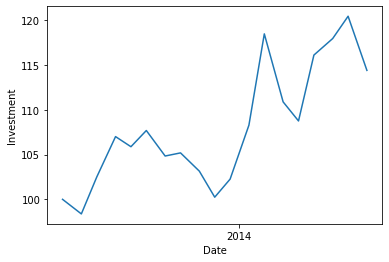

In [80]:
x = portfolio["Dates"]
y = portfolio["Investment"]

ax = plt.gca()
ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator([1, 7]))
ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter('%b'))
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
#ax.tick_params(pad=20)

plt.xlabel('Date')
plt.ylabel('Investment')
plt.plot(x,y)
plt.savefig(f"{parameter}.jpg")
#plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


##### Prova returns

In [ ]:
ciao = df_stocks[list(df_top_titles["Title"])][:7]

NameError: name 'df_top_titles' is not defined

In [ ]:
ciao["Vivendi SA"].loc["2002-01-18"] = np.nan
ciao["Orange SA"] = np.nan
ciao.head(4)

KeyError: 'Vivendi SA'

In [ ]:
ciao["Orange SA"].sum()

In [ ]:
ciao["Vivendi SA"].sum()

In [ ]:
returns(ciao)

In [ ]:
pd.DataFrame(columns=['Dates'] + [f'Title{i}' for i in range(1,11)] + ['Returns'])

In [ ]:
alpha = regression.params[0]
alpha_significance = regression.pvalues[0]
beta = regression.params[1]
r2 = regression.rsquared
specific_risk = regression.resid.std()
absolute_returns = sum(title_returns)

In [ ]:
alpha = regression.params[0]
alpha_significance = regression.pvalues[0]
beta = regression.params[1]
r2 = regression.rsquared
specific_risk = regression.resid.std()
absolute_returns = sum(title_returns) 

NameError: name 'regression' is not defined

In [ ]:
log_returns_stocks.reset_index(inplace=True)

# Altre prove

##### Results

In [ ]:
df_stocks, df_index = df_window(1110)

df_results = parameters_df_window(df_stocks, df_index)

<ipython-input-15-12c5c345284f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stocks.dropna(axis = 1, how='any', inplace=True)
C:\Users\Ale\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [ ]:
df_top_titles = top_titles(df_results, "high_systematic_risk")

In [ ]:
parameters = ["high_r2", "high_specific_risk", "absolute_returns", "high_alpha", "high_systematic_risk"] 

# Returns
### il formato del dataframe che si da in pasto a "returns" deve essere uguale a quello descritto sotto

In [ ]:
selected_stocks = list(df_top_titles["Title"])

In [ ]:
#df_stocks[selected_stocks][rolling_window + days -7 : rolling_window + days]
log_returns_stocks[selected_stocks][rolling_window + 7 - 7 : rolling_window + 7]

,Booker Group PLC,TNU SA,Banca Nazionale del Lavoro SpA,LHR Airports Ltd,Pilkington Group Ltd,BOC Group Ltd/The,Alpiq Holding AG,Buderus AG,Chubb PLC,Allied Domecq Ltd
Dates,,,,,,,,,,
2002-09-11,NaN,0.011696,0.006336,0.014713,0.022352,0.013990,-0.006323,0.019245,-0.017756,-0.010647
2002-09-12,NaN,-0.023530,-0.036395,-0.010255,-0.018381,-0.016017,-0.002325,-0.010750,0.029906,-0.028951
2002-09-13,NaN,0.000000,0.008670,-0.006287,-0.021854,-0.013300,-0.001176,0.010285,-0.021735,-0.003642
2002-09-16,NaN,0.000000,0.005029,0.010147,-0.018634,-0.009597,0.001343,-0.023530,-0.033599,-0.001547
2002-09-17,NaN,-0.011976,-0.013699,0.007954,-0.059053,0.008764,-0.002055,-0.063904,-0.004323,0.005112
2002-09-18,NaN,0.011976,-0.019767,0.001697,-0.052064,-0.054533,0.000000,-0.061228,-0.055786,-0.012582
2002-09-19,NaN,0.000000,0.029201,-0.037447,-0.020009,0.001165,0.030871,0.002695,-0.037971,0.006469
